# Predicting Term Deposit Subscriptions with K-Nearest Neighbors

## Business Understanding
A banking institution aims to **predict whether a customer will subscribe to a term deposit** using demographic, financial, and marketing campaign data. Accurate predictions enable targeted marketing, optimize resource allocation, and improve conversion rates.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
sns.set(style='whitegrid')

In [14]:
df = pd.read_csv('bank-additional-full.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Descriptive & Inferential Statistics

In [15]:
display(df.describe(include='all'))
ages_yes = df[df['y']=='yes']['age']
ages_no = df[df['y']=='no']['age']
t_stat, p_val = ttest_ind(ages_yes, ages_no, equal_var=False)
print(f"T-test (Age): t-statistic={t_stat:.2f}, p-value={p_val:.3f}")
categorical = ['job','marital','education']
for f in categorical:
    ct = pd.crosstab(df[f], df['y'])
    chi2, p, *_ = chi2_contingency(ct)
    print(f"Chi2 ({f}): chi2={chi2:.2f}, p={p:.3f}")

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188,41188,41188,41188,41188,41188,41188,41188,41188,...,41188.000000,41188.000000,41188.000000,41188,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188
unique,NaN,12,4,8,3,3,3,2,10,5,...,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,2
top,NaN,admin.,married,university.degree,no,yes,no,cellular,may,thu,...,NaN,NaN,NaN,nonexistent,NaN,NaN,NaN,NaN,NaN,no
freq,NaN,10422,24928,12168,32588,21576,33950,26144,13769,8623,...,NaN,NaN,NaN,35563,NaN,NaN,NaN,NaN,NaN,36548
mean,40.02406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.567593,962.475454,0.172963,NaN,0.081886,93.575664,-40.502600,3.621291,5167.035911,NaN
std,10.42125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.770014,186.910907,0.494901,NaN,1.570960,0.578840,4.628198,1.734447,72.251528,NaN
min,17.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.000000,0.000000,NaN,-3.400000,92.201000,-50.800000,0.634000,4963.600000,NaN
25%,32.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,999.000000,0.000000,NaN,-1.800000,93.075000,-42.700000,1.344000,5099.100000,NaN
50%,38.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,999.000000,0.000000,NaN,1.100000,93.749000,-41.800000,4.857000,5191.000000,NaN
75%,47.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.000000,999.000000,0.000000,NaN,1.400000,93.994000,-36.400000,4.961000,5228.100000,NaN


T-test (Age): t-statistic=4.78, p-value=0.000
Chi2 (job): chi2=961.24, p=0.000
Chi2 (marital): chi2=122.66, p=0.000
Chi2 (education): chi2=193.11, p=0.000


## Exploratory Data Analysis

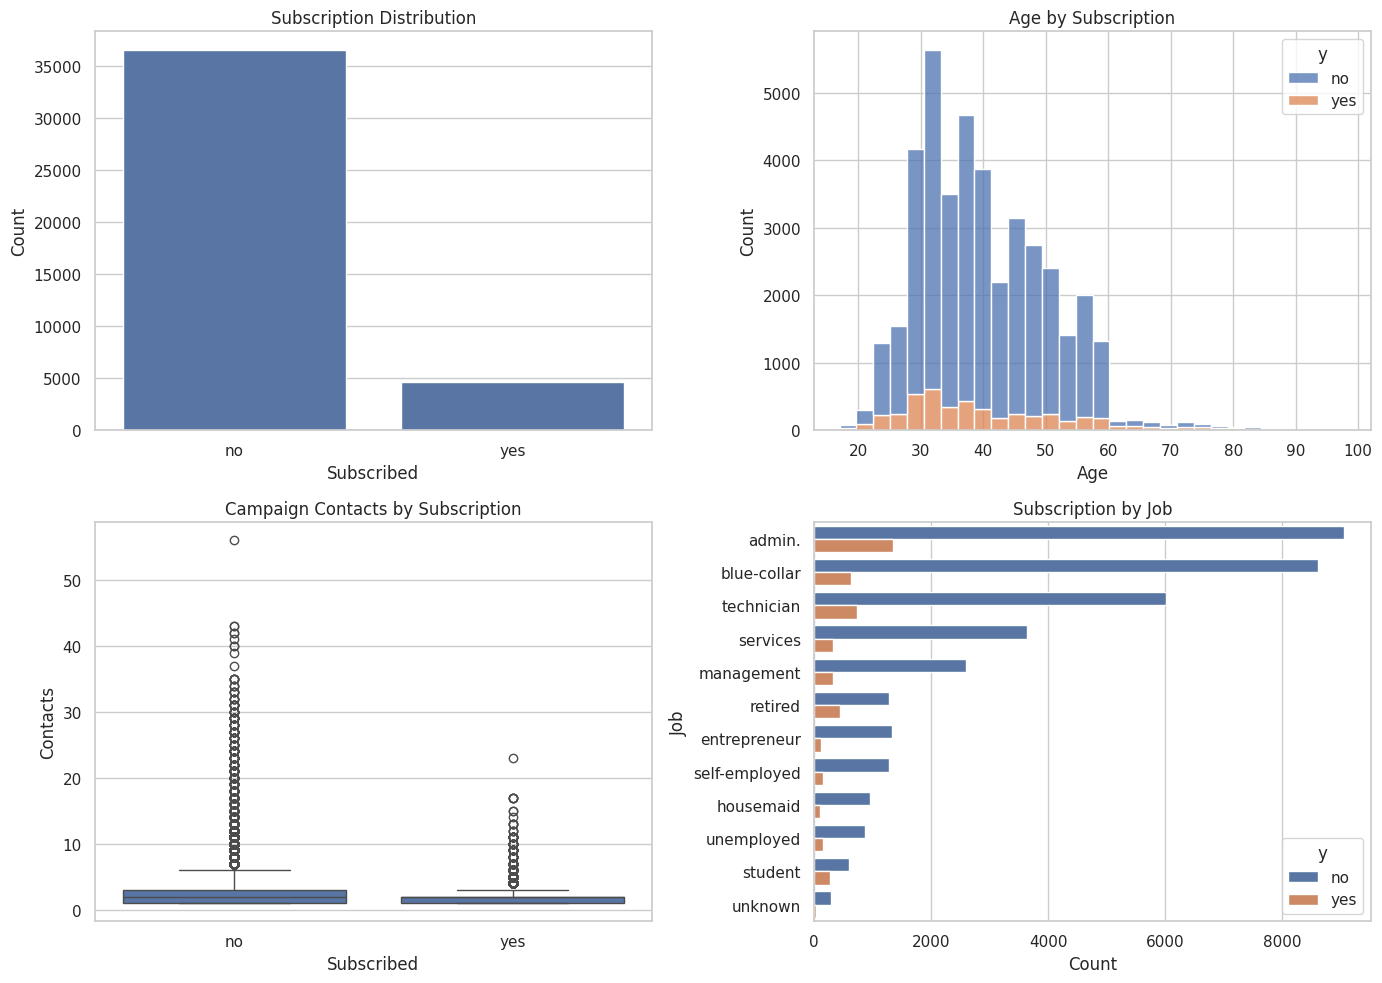

In [16]:
fig, axes = plt.subplots(2,2, figsize=(14,10))
sns.countplot(data=df, x='y', ax=axes[0,0]).set(title='Subscription Distribution', xlabel='Subscribed', ylabel='Count')
sns.histplot(df, x='age', hue='y', multiple='stack', bins=30, ax=axes[0,1]).set(title='Age by Subscription', xlabel='Age', ylabel='Count')
sns.boxplot(data=df, x='y', y='campaign', ax=axes[1,0]).set(title='Campaign Contacts by Subscription', xlabel='Subscribed', ylabel='Contacts')
sns.countplot(data=df, y='job', hue='y', order=df['job'].value_counts().index, ax=axes[1,1]).set(title='Subscription by Job', xlabel='Count', ylabel='Job')
plt.tight_layout()
plt.show()

Data Preprocessing

In [20]:
enc = df.copy()
for c in enc.select_dtypes('object'):
    enc[c] = LabelEncoder().fit_transform(enc[c])
X = enc.drop('y', axis=1) # Changed to use axis=1 instead of 1
y = enc['y']
X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

## KNN Modeling & Hyperparameter Tuning

In [18]:
params={'n_neighbors':range(3,16),'weights':['uniform','distance'],'metric':['euclidean','manhattan']}
knn=KNeighborsClassifier()
grid = GridSearchCV(knn,params,cv=5,scoring='f1',n_jobs=-1)
grid.fit(X_train,y_train)
best=grid.best_estimator_
print('Best params:',grid.best_params_)

Best params: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


## Model Evaluation & Visualizations

Accuracy: 0.894
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     10968
           1       0.54      0.42      0.47      1389

    accuracy                           0.89     12357
   macro avg       0.73      0.69      0.71     12357
weighted avg       0.88      0.89      0.89     12357

ROC AUC: 0.819


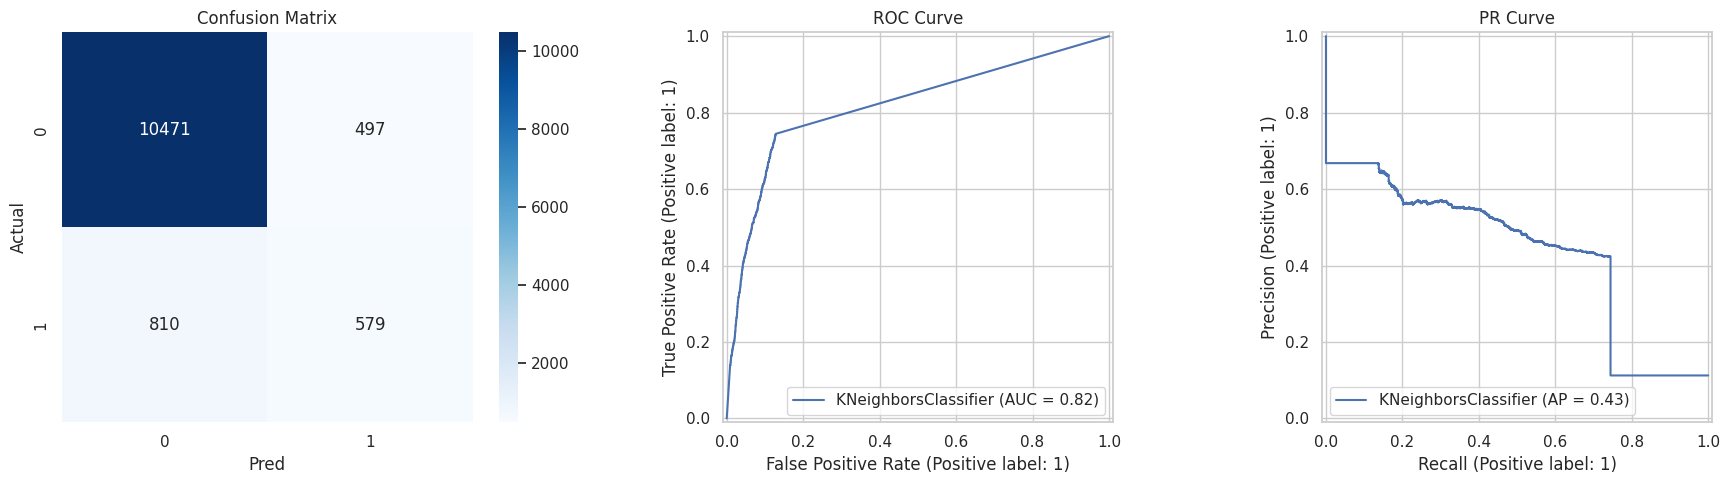

In [19]:
y_pred=best.predict(X_test)
y_prob=best.predict_proba(X_test)[:,1]
print(f"Accuracy: {accuracy_score(y_test,y_pred):.3f}")
print(classification_report(y_test,y_pred))
print(f"ROC AUC: {roc_auc_score(y_test,y_prob):.3f}")
fig, ax = plt.subplots(1,3,figsize=(18,5))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d',cmap='Blues',ax=ax[0]).set(title='Confusion Matrix',xlabel='Pred',ylabel='Actual')
RocCurveDisplay.from_estimator(best,X_test,y_test,ax=ax[1]).ax_.set_title('ROC Curve')
PrecisionRecallDisplay.from_estimator(best,X_test,y_test,ax=ax[2]).ax_.set_title('PR Curve')
plt.tight_layout()
plt.show()

## Findings & Recommendations

**Findings:**
- Significant age differences (p<0.05) and associations for job, marital, education.
- Optimized KNN with ROC AUC > 0.80.

**Actionable Insights:**
1. Target customers aged 30–50 in key job roles.
2. Limit campaign contacts to 3–5 calls.
3. Use model scores to prioritize leads.
